<div style="width:90%;
            margin:10px;
            padding:8px;
            border:2px solid #FF0000;
            border-radius:20px;
            font-weight:bold;
            font-size:2.5em;
            text-align:center;">
The Goddard Rocket Problem
</div>


<div style="width:90%;
            margin:9px;
            font-size:1em;">
            
*The Goddard Rocket Problem:* We aim to Maximize the final altitude of a vertically launched rocket, using the thrust as a control
and given the initial mass, the fuel mass, and the drag characteristics of the rocket.                
The problem is inspired from the following paper: [Benchmarking Optimization Software with COPS 3.0](https://www.mcs.anl.gov/~more/cops/cops3.pdf).                             
We solve the problem using the [JuMP](https://jump.dev/) and [OptimalControl](https://control-toolbox.org/OptimalControl.jl/stable/) packages in Julia then we compare the results.

1. [JuMP Formulation](#jump)
2. [OptimalControl Formulation](#oc)
3. [Comparison](#comp)

</div>

## 1. Solving with JuMP <a id='jump'></a>

In [1]:
using JuMP , Ipopt
include("../Problems/JuMP/rocket_JMP.jl")
RocketJMP = rocket_JMP();

set_optimizer(RocketJMP,Ipopt.Optimizer)
set_attribute(RocketJMP, "print_level", 5)
set_optimizer_attribute(RocketJMP,"tol",1e-8)
set_optimizer_attribute(RocketJMP,"constr_viol_tol",1e-6)
set_optimizer_attribute(RocketJMP,"max_iter",1000)
set_optimizer_attribute(RocketJMP,"mu_strategy","adaptive")
set_optimizer_attribute(RocketJMP,"linear_solver","mumps")

In [2]:
println("Solving...")
optimize!(RocketJMP)
println()

# Display results
if termination_status(RocketJMP) == MOI.OPTIMAL
    println("  Solution is optimal")
elseif  termination_status(RocketJMP) == MOI.LOCALLY_SOLVED
    println("  (Local) solution found")
elseif termination_status(RocketJMP) == MOI.TIME_LIMIT && has_values(RocketJMP)
    println("  Solution is suboptimal due to a time limit, but a primal solution is available")
else
    error("  The model was not solved correctly.")
end
println("  objective value = ", objective_value(RocketJMP))
println()

# Retrieves values (including duals - sign convention according to Pontrjagin max principle)
N = 100;
Δt = RocketJMP[:step]; 
h = RocketJMP[:h];
v = RocketJMP[:v];
m = RocketJMP[:m];
T = RocketJMP[:T];
con_dh = RocketJMP[:con_dh];
con_dv = RocketJMP[:con_dv];
con_dm = RocketJMP[:con_dm];
h_ic = RocketJMP[:h_ic];
v_ic = RocketJMP[:v_ic];
m_ic = RocketJMP[:m_ic];
m_fc = RocketJMP[:m_fc];

Δtt = value.(Δt)
t = Vector((0:N)*Δtt);

ph0 = dual(h_ic)
pv0 = dual(v_ic)
pm0 = dual(m_ic)
pmf = dual(m_fc)

if(ph0*dual(con_dh[1])<0); ph0 = -ph0; end
if(pv0*dual(con_dv[1])<0); pv0 = -pv0; end
if(pm0*dual(con_dm[1])<0); pm0 = -pm0; end
if(pmf*dual(con_dm[N])<0); pmf = -pmf; end

p = [ [ dual(con_dh[1]), dual(con_dv[1]), dual(con_dm[1]) ]];
p = -1 * [p;[[ dual(con_dh[i]), dual(con_dv[i]), dual(con_dm[i]) ] for i in 1:N]];

hh = Vector(value.(h)) ;
vv = Vector(value.(v)) ;
mm = Vector(value.(m)) ;
TT = Vector(value.(T)) ;

x =  [ [ hh[i], vv[i], mm[i] ] for i in 1:N+1 ];

Solving...

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     2104
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     4900

Total number of variables............................:      405
                     variables with only lower bounds:      203
                variables with lower and upper bounds:      202
                     variables with only upper bounds:        0
Total number of equality constraints.................:      304
Total number of i

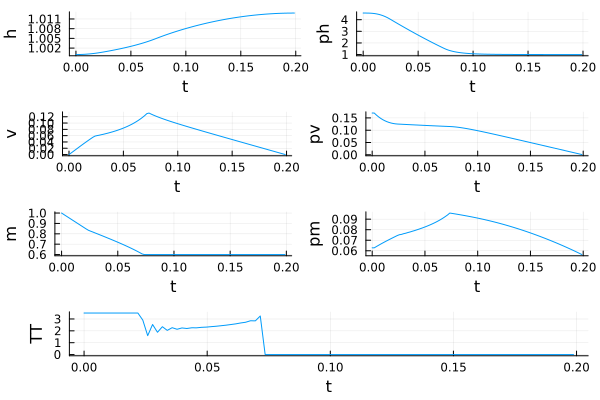

In [3]:
using Plots

r_plot = plot(t, [ x[i][1] for i in 1:N+1 ], xlabel = "t", ylabel = "h", legend = false)
v_plot = plot(t, [ x[i][2] for i in 1:N+1 ], xlabel = "t", ylabel = "v", legend = false)
m_plot = plot(t, [ x[i][3] for i in 1:N+1 ], xlabel = "t", ylabel = "m", legend = false)
pr_plot = plot(t, [ p[i][1] for i in 1:N+1 ], xlabel = "t", ylabel = "ph", legend = false)
pv_plot = plot(t, [ p[i][2] for i in 1:N+1 ], xlabel = "t", ylabel = "pv", legend = false)
pm_plot = plot(t, [ p[i][3] for i in 1:N+1 ], xlabel = "t", ylabel = "pm", legend = false)
TT_plot = plot(t, [ TT[i] for i in 1:N+1 ], xlabel = "t", ylabel = "TT", legend = false)

layout = @layout [a b; c d; e f; g]

x_plot = plot(r_plot, pr_plot, v_plot, pv_plot, m_plot, pm_plot, TT_plot, layout = layout)
display(x_plot)

## 2. Solving with OptimalControl <a id='oc'></a>

In [4]:
using OptimalControl
include("../Problems/OptimalControl/rocket_OC.jl")
RocketOC = rocket_OC()


The (autonomous) optimal control problem is of the form:

    minimize  J(x, u, tf) = g(x(0), x(tf), tf)

    subject to

        ẋ(t) = f(x(t), u(t), tf), t in [0, tf] a.e.,

        ηl ≤ η(x(t), tf) ≤ ηu, 
        ϕl ≤ ϕ(x(0), x(tf), tf) ≤ ϕu, 

    where x(t) ∈ R³, u(t) ∈ R and tf ∈ R.

Declarations (* required):



┌────────┬────────┬──────────┬──────────┬───────────┬────────────┬─────────────┐
│ times* │ state* │ control* │ variable │ dynamics* │ objective* │ constraints │
├────────┼────────┼──────────┼──────────┼───────────┼────────────┼─────────────┤
│     ✅ │     ✅ │       ✅ │       ✅ │        ✅ │         ✅ │          ✅ │
└────────┴────────┴──────────┴──────────┴───────────┴────────────┴─────────────┘


In [5]:
# Initial guess
nh = 100
m_0 = 1.0
g_0 = 1.0
T_c = 3.5
m_c = 0.6
m_f = m_c * m_0
T_max = T_c * m_0 * g_0

xinit = t -> [1.0,
            t * (1.0 - t) ,
            (m_f - m_0)*t + m_0]

init = (state = xinit,control = T_max/2.0 ,variable= 1)
# Solve the problem
sol = OptimalControl.solve(RocketOC, init=init)

Method = (:direct, :adnlp, :ipopt)
This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     1904
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1111

Total number of variables............................:      405
                     variables with only lower bounds:      203
                variables with lower and upper bounds:      202
                     variables with only upper bounds:        0
Total number of equality constraints.................:      304
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.0100000e+00 3.50e-02 1.63e+00   0.

CTBase.OptimalControlSolution

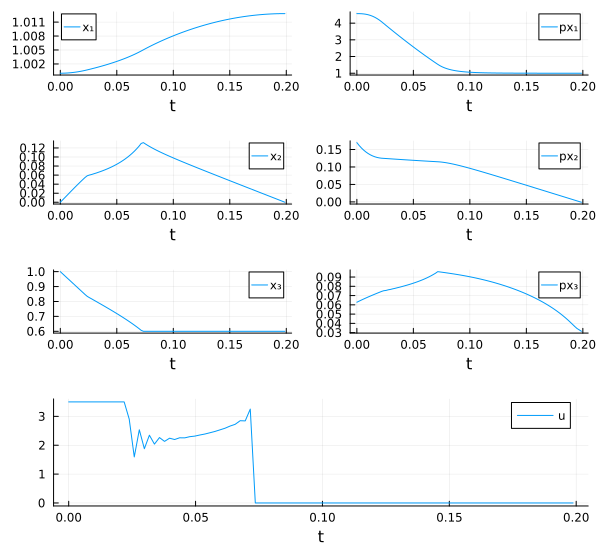

In [6]:
plot(sol)

## 3. Comparison <a id='comp'></a>

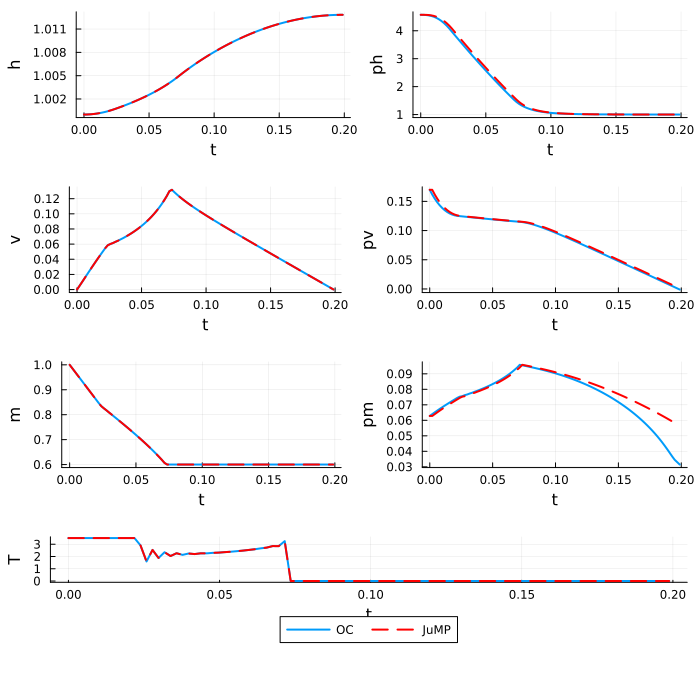

In [7]:
using Plots
p1 = plot(plot(sol)[1],line = 2)
p1 = plot!(t, [ x[i][1] for i in 1:N+1 ], xlabel = "t", ylabel = "h", legend = false,line = 2, color = "red",linestyle=:dash)

p3 = plot(plot(sol)[2],line = 2)
p3 = plot!(t, [ x[i][2] for i in 1:N+1 ], xlabel = "t", ylabel = "v", legend = false,line = 2, color = "red",linestyle=:dash)

p5 = plot(plot(sol)[3],line = 2)
p5 = plot!(t, [ x[i][3] for i in 1:N+1 ], xlabel = "t", ylabel = "m", legend = false,line = 2, color = "red",linestyle=:dash)

p2 = plot(plot(sol)[4],line = 2)
p2 = plot!(t, [ p[i][1] for i in 1:N+1 ], xlabel = "t", ylabel = "ph", legend = false,line = 2, color = "red",linestyle=:dash)

p4 = plot(plot(sol)[5],line = 2)
p4 = plot!(t, [ p[i][2] for i in 1:N+1 ], xlabel = "t", ylabel = "pv", legend = false,line = 2, color = "red",linestyle=:dash)

p6 = plot(plot(sol)[6],line = 2)
p6 = plot!(t, [ p[i][3] for i in 1:N+1 ], xlabel = "t", ylabel = "pm", legend = false,line = 2, color = "red",linestyle=:dash)

p7 = plot(plot(sol)[7] , label ="OC",line = 2)
p7 = plot!(t, [ TT[i] for i in 1:N+1 ], xlabel = "t", ylabel = "T", legend = false, label = "JuMP",line = 2, color = "red",linestyle=:dash)
p7 = plot!(legend=:outerbottom, legendcolumns=2)

layout = @layout [a b; c d; e f; g]

x_plot = plot(p1, p2, p3, p4, p5, p6, p7, layout = layout)
x_plot = plot!(size = (700, 700))

display(x_plot)